In [0]:
!nvidia-smi

Mon Sep 30 21:36:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |    795MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import matplotlib.pyplot as plt
!pip install imgaug
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random
from sklearn.model_selection import train_test_split


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda

# for visualisation
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [0]:
X = np.load('X.npy')
y = np.load('y.npy')

In [0]:
print(X.shape, y.shape)

(8943, 60, 80, 3) (8943,)


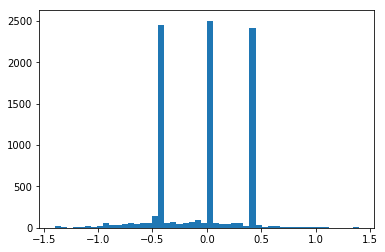

In [0]:
plt.hist(y, 50);

## Image processing

0.0


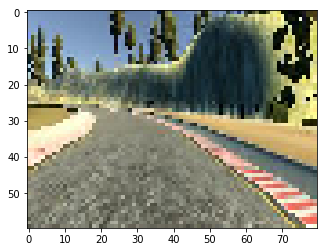

0.07500000000000001


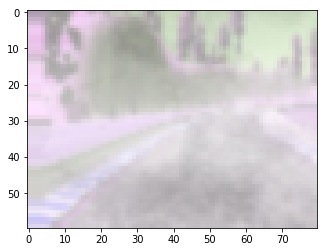

In [0]:
# We are processing the image to have more examples

def augment(img, steering_angle):
  # Flip
  if random.random() > 0.5:
    img = img[:, ::-1,:]
    steering_angle = -steering_angle
  # Blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1,1.0))
  img = images_avg = blurer.augment_image(img)
  # shuffle
  sh = iaa.ChannelShuffle(p=0.5)
  img = sh.augment_image(img)
  # fog
  fog = iaa.Fog()
  img = fog.augment_image(img)
  # translater
  tx = random.randint(-20,20) # edge - to stretch image instead of having black space
  translater = iaa.Affine(translate_px={"x":tx}, mode='edge')
  img = translater.augment_image(img)
  steering_angle += tx*0.025 
  
  return img, steering_angle
  
plt.imshow(X[0])  
print(y[0])
plt.show();
  
img, angle = augment(X[0], y[0])
plt.imshow(img)
print(angle)
plt.show();

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=42)

In [0]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7154, 60, 80, 3) (7154,)
(1789, 60, 80, 3) (1789,)


In [0]:
Xgen=[]
ygen=[]
for i in range(1000):
  img, angle = augment(X[i],y[i])
  Xgen.append(img)
  ygen.append(angle)
  
Xgen = np.array(Xgen)
ygen = np.array(ygen)
print(Xgen.shape, ygen.shape)

(1000, 60, 80, 3) (1000,)


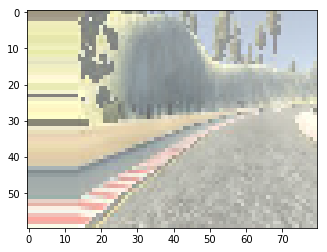

In [0]:
plt.imshow(Xgen[0])

(array([ 2.,  0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  1.,  3.,  2.,  1.,
         3.,  3.,  3., 52., 42., 47., 44., 73., 56., 50., 43., 45., 67.,
        43., 39., 39., 60., 48., 34., 58., 83., 24.,  7.,  6.,  3.,  3.,
         2.,  1.,  0.,  2.,  0.,  0.,  0.,  3.,  0.,  0.,  1.]),
 array([-1.425, -1.369, -1.313, -1.257, -1.201, -1.145, -1.089, -1.033,
        -0.977, -0.921, -0.865, -0.809, -0.753, -0.697, -0.641, -0.585,
        -0.529, -0.473, -0.417, -0.361, -0.305, -0.249, -0.193, -0.137,
        -0.081, -0.025,  0.031,  0.087,  0.143,  0.199,  0.255,  0.311,
         0.367,  0.423,  0.479,  0.535,  0.591,  0.647,  0.703,  0.759,
         0.815,  0.871,  0.927,  0.983,  1.039,  1.095,  1.151,  1.207,
         1.263,  1.319,  1.375]),
 <a list of 50 Patch objects>)

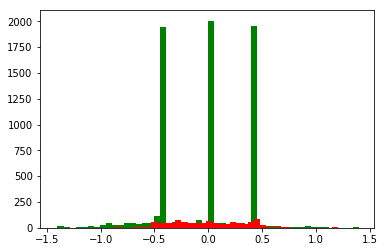

In [0]:
plt.hist(y_train, 50, facecolor='green')
plt.hist(ygen, 50, facecolor='red')

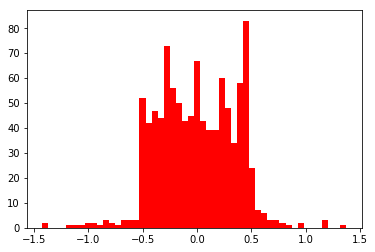

In [0]:
plt.hist(ygen, 50, facecolor='red');

## Model

In [0]:
def myModel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x-128.0)/255.0, input_shape=input_shape, name='normalize'), # convert image
      Conv2D(64,(3,3), activation='relu'), #convolution
      Conv2D(32,(3,3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)), # generalisation; make model 4x smaller
      Conv2D(16,(3,3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(8,(3,3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(rate=0.5), # generalisation
      Flatten(), # reduce multidimensionality
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(16, activation='relu'),
      Dense(1)
  ])
  return model

model = myModel(X[0].shape)
model.summary()
model.compile('adam', 'mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 36, 16)        4624      
_________________________________________________________________

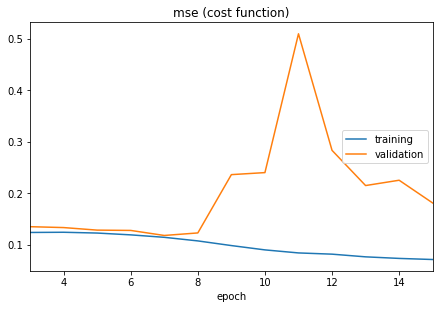

mse (cost function):
training   (min:    0.071, max:    0.124, cur:    0.071)
validation (min:    0.118, max:    0.510, cur:    0.181)


In [0]:
batch_size = 512
epochs = 15

model.fit(Xgen, ygen, 
          batch_size = batch_size,
          epochs = epochs,
          validation_data = (X_val, y_val),
          callbacks=[PlotLossesKeras()]
         )

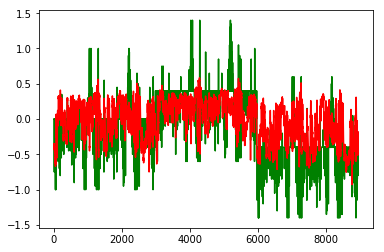

In [0]:
ypred = model.predict(X)
plt.plot(y, 'g', ypred, 'r')
plt.show();

In [0]:
model.save('mymodel.h5')

In [0]:
!pip install autokeras

In [0]:
!pip uninstall torch torchvision -y

!pip install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
!pip install torchvision==0.2.1

In [0]:
import autokeras as ak

In [0]:
model_ak = ak.ImageRegressor(verbose=True)
model_ak.fit(Xgen, ygen, time_limit=30*60)

Saving Directory: /tmp/autokeras_8M747P
Preprocessing the images.
Preprocessing finished.

Initializing search.
Initialization finished.


+----------------------------------------------+
|               Training model 0               |
+----------------------------------------------+
                                                                                                    
No loss decrease after 5 epochs.


Saving model.
+--------------------------------------------------------------------------+
|        Model ID        |          Loss          |      Metric Value      |
+--------------------------------------------------------------------------+
|           0            |  0.11001053899526596   |  0.11001054025268553   |
+--------------------------------------------------------------------------+


+----------------------------------------------+
|               Training model 1               |
+----------------------------------------------+
Epoch-1, Current Metric - 0: 1